In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import ants
import matplotlib.pyplot as plt
import seaborn as sns

from notebooks.histogram_comparison import atlas_brainmask
from src.improved_padding import ImprovedPadding
from src.utils import get_mask, compute_js_divergence, compute_kl_divergence, detect_outliers

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
dir_hd = Path("/media/maichi/T7")
list_patients = (dir_hd / "list_patients.txt").read_text().split("\n")
list_patients = [list_patients[i] for i in np.argsort([int(patient.strip("AIDREAM_")) for patient in list_patients if patient.startswith("AIDREAM_")])]
print("Nbr of patients: ", len(list_patients))
list_patients = list_patients

list_biomarkers = ["CTH"]
list_interpolators = ["linear", "bSpline", "lanczosWindowedSinc", "nearestNeighbor", "genericLabel"]



Nbr of patients:  186


In [3]:
# register biomarkers for all patients, using different interpolation methods :
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    for biomarker in list_biomarkers:
        for interpolator in list_interpolators:

            print(fr"Registering CTH for patient={patient}, interpolator={interpolator}")
            padder.register("CTH", interpolator=interpolator)


Processing patient 1/186 : AIDREAM_1
Registering CTH for patient=AIDREAM_1, interpolator=linear
Registering CTH for patient=AIDREAM_1, interpolator=bSpline
Registering CTH for patient=AIDREAM_1, interpolator=lanczosWindowedSinc
Registering CTH for patient=AIDREAM_1, interpolator=nearestNeighbor
Registering CTH for patient=AIDREAM_1, interpolator=genericLabel
Processing patient 2/186 : AIDREAM_2
Registering CTH for patient=AIDREAM_2, interpolator=linear
Registering CTH for patient=AIDREAM_2, interpolator=bSpline
Registering CTH for patient=AIDREAM_2, interpolator=lanczosWindowedSinc
Registering CTH for patient=AIDREAM_2, interpolator=nearestNeighbor
Registering CTH for patient=AIDREAM_2, interpolator=genericLabel
Processing patient 3/186 : AIDREAM_3
Registering CTH for patient=AIDREAM_3, interpolator=linear
Registering CTH for patient=AIDREAM_3, interpolator=bSpline
Registering CTH for patient=AIDREAM_3, interpolator=lanczosWindowedSinc
Registering CTH for patient=AIDREAM_3, interpolato

In [4]:
# Register the brainmask for all patients, using genericLabel interpolation:
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    print(fr"Registering brainmask for patient={patient}, interpolator=genericLabel")
    padder.register("brainmask", interpolator="genericLabel")


Processing patient 1/186 : AIDREAM_1
Registering brainmask for patient=AIDREAM_1, interpolator=genericLabel
Processing patient 2/186 : AIDREAM_2
Registering brainmask for patient=AIDREAM_2, interpolator=genericLabel
Processing patient 3/186 : AIDREAM_3
Registering brainmask for patient=AIDREAM_3, interpolator=genericLabel
Processing patient 4/186 : AIDREAM_4
Registering brainmask for patient=AIDREAM_4, interpolator=genericLabel
Processing patient 5/186 : AIDREAM_6
Registering brainmask for patient=AIDREAM_6, interpolator=genericLabel
Processing patient 6/186 : AIDREAM_7
Registering brainmask for patient=AIDREAM_7, interpolator=genericLabel
Processing patient 7/186 : AIDREAM_9
Registering brainmask for patient=AIDREAM_9, interpolator=genericLabel
Processing patient 8/186 : AIDREAM_10
Registering brainmask for patient=AIDREAM_10, interpolator=genericLabel
Processing patient 9/186 : AIDREAM_11
Registering brainmask for patient=AIDREAM_11, interpolator=genericLabel
Processing patient 10/18

In [5]:
# Resample the brainmask for all patients, using genericLabel interpolation :
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    print(fr"Resampling brainmask for patient={patient}, interpolator=genericLabel")
    padder.register("brainmask", interpolator="genericLabel")


Processing patient 1/186 : AIDREAM_1
Resampling brainmask for patient=AIDREAM_1, interpolator=genericLabel
Processing patient 2/186 : AIDREAM_2
Resampling brainmask for patient=AIDREAM_2, interpolator=genericLabel
Processing patient 3/186 : AIDREAM_3
Resampling brainmask for patient=AIDREAM_3, interpolator=genericLabel
Processing patient 4/186 : AIDREAM_4
Resampling brainmask for patient=AIDREAM_4, interpolator=genericLabel
Processing patient 5/186 : AIDREAM_6
Resampling brainmask for patient=AIDREAM_6, interpolator=genericLabel
Processing patient 6/186 : AIDREAM_7
Resampling brainmask for patient=AIDREAM_7, interpolator=genericLabel
Processing patient 7/186 : AIDREAM_9
Resampling brainmask for patient=AIDREAM_9, interpolator=genericLabel
Processing patient 8/186 : AIDREAM_10
Resampling brainmask for patient=AIDREAM_10, interpolator=genericLabel
Processing patient 9/186 : AIDREAM_11
Resampling brainmask for patient=AIDREAM_11, interpolator=genericLabel
Processing patient 10/186 : AIDRE

In [ ]:
def get_pct(image):
    mask_image = get_mask(image.numpy())
    values = image[mask_image == 1].flatten()
    return np.mean(values)

path_results = Path.cwd().parent / "data" / "brainmask_coverage.csv"
if path_results.exists():
    df_brainmask_coverage = pd.read_csv(str(path_results))
else:

    df_brainmask_coverage = pd.DataFrame(columns=["patient", "brainmask", "brainmask_resampled", "brainmask_registered"])

    # Compare the percentage of non-zero voxels in the brainmask for all patients :
    for i, patient in enumerate(list_patients):

        print(f"Processing patient {i+1}/{len(list_patients)} : {patient}")
        padder = ImprovedPadding(patient)

        # Load the GT brainmask:
        brainmask = padder.get_biomarker("brainmask")
        pct_gt = get_pct(brainmask)

        # Load the resampled brainmask:
        brainmask_resampled = padder.get_resampled_biomarker("brainmask", interpolator="genericLabel")
        pct_resampled = get_pct(brainmask_resampled)

        # Load the registered brainmask:
        brainmask_registered = padder.get_atlas_biomarker("brainmask", interpolator="genericLabel")
        pct_registered = get_pct(brainmask_registered)

        # Compute the percentage of non-zero voxels :
        df_brainmask_coverage.loc[len(df_brainmask_coverage)] = [patient, pct_gt, pct_resampled, pct_registered]

    df_brainmask_coverage.to_csv(path_results, index=False)


Processing patient 1/186 : AIDREAM_1
Processing patient 2/186 : AIDREAM_2
Processing patient 3/186 : AIDREAM_3


In [6]:
def get_histogram(image, p, bins = None) -> np.ndarray:

    mask_image = get_mask(image)
    image_values = image[mask_image == 1].flatten()
    image_values = np.round(image_values, p)

    if bins is None:
        bin_width = 10**-p
        min_val = np.floor(np.min(image_values) / bin_width) * bin_width
        max_val = np.ceil(np.max(image_values) / bin_width) * bin_width
        bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Compute the histogram :
    hist_image, bins_image = np.histogram(image_values, bins=bins, density=True)

    return hist_image, bins_image


In [29]:
# Compare JS divergence between resampled and non-resampled images :
# And compare the KL divergence with the ground truth for both resampled and non-resampled images :
path_results = Path.cwd().parent / "data" / "js_divergence_CTH_interpolators.csv"

if path_results.exists():
    df_js_divergence = pd.read_csv(str(path_results))
else:

    df_js_divergence = pd.DataFrame(columns=["patient", "interpolator", "JS divergence resampled vs non-resampled", "KL divergence resampled", "KL divergence non-resampled"])


    for i, patient in enumerate(list_patients):

        print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")

        for interpolator in list_interpolators:
            print(f"patient={patient}, interpolator={interpolator}")

            padder = ImprovedPadding(patient)

            # Load the ground truth cth, and the brainmask :
            cth, brainmask = padder.get_biomarker("CTH").numpy(), padder.get_biomarker("brainmask").numpy()
            cth = cth * brainmask

            # Load the registered cth and its brainmask :
            atlas_cth, atlas_brainmask = padder.get_atlas_biomarker("CTH").numpy(), padder.get_atlas_biomarker("brainmask").numpy()
            atlas_cth = atlas_cth * atlas_brainmask

            # Compute the histograms :
            hist_cth, bins_cth = get_histogram(cth, p=2, bins=100)
            hist_atlas_cth, bins_atlas_cth = get_histogram(atlas_cth, p=2, bins=bins_cth)

            # Compute the JS divergence between the resampled and non-resampled atlas cth :
            js_divergence = compute_js_divergence(hist_cth, hist_atlas_cth)

            # Compute the KL divergence between the ground truth and the resampled atlas cth :
            kl_divergence_resampled = compute_kl_divergence(hist_cth, hist_atlas_cth_resampled)

            # Compute the KL divergence between the ground truth and the non-resampled atlas cth :
            kl_divergence_not_resampled = compute_kl_divergence(hist_cth, hist_atlas_cth_not_resampled)

            df_js_divergence.loc[len(df_js_divergence)] = [patient, interpolator, js_divergence, kl_divergence_resampled, kl_divergence_not_resampled]

    df_js_divergence.to_csv(str(path_results), index=False)


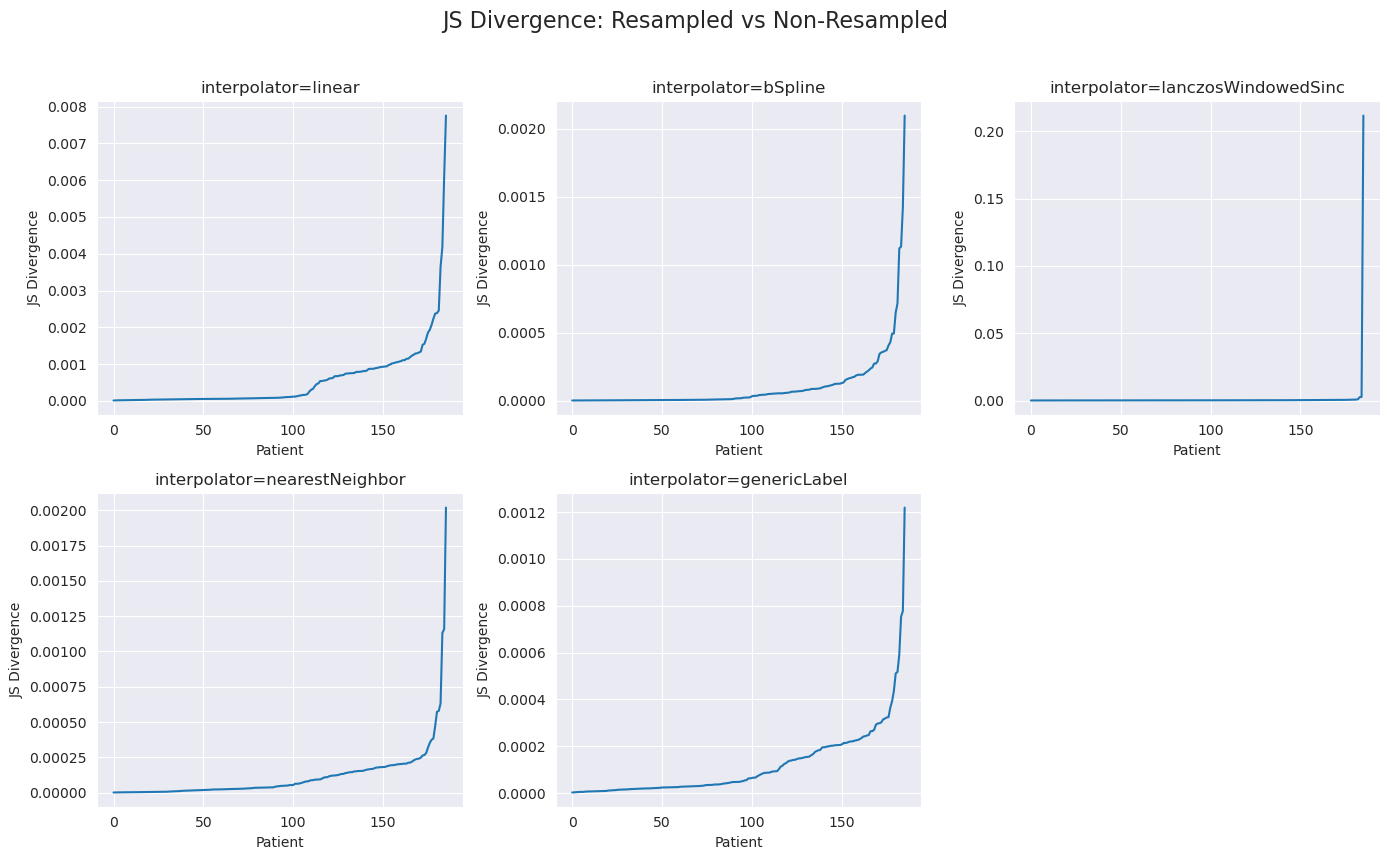

In [30]:
# Create the figure
fig = plt.figure(figsize=(14, 9))
fig.suptitle("JS Divergence: Resampled vs Non-Resampled", fontsize=16, y=0.95)

for idx, interpolator in enumerate(list_interpolators):

    ax = fig.add_subplot(2, 3, idx+1)
    _df_js_divergence = df_js_divergence.loc[df_js_divergence["interpolator"] == interpolator]

    js_data = _df_js_divergence["JS divergence resampled vs non-resampled"].sort_values().reset_index(drop=True)

    # Plot the JS divergence values :
    js_data.plot(ax=ax)
    ax.set_xlabel("Patient")
    ax.set_ylabel("JS Divergence")
    ax.set_title(f"interpolator={interpolator}")


# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [31]:
# Determine the outliers :
df_outliers = detect_outliers(df_js_divergence, "KL divergence resampled", multiplier=1.96)
outlier_patients_resampled = set(df_outliers["patient"])
print(f"Outliers based on KL divergence resampled : {outlier_patients_resampled}")

df_outliers = detect_outliers(df_js_divergence, "KL divergence non-resampled", multiplier=1.96)
outlier_patients_non_resampled = set(df_outliers["patient"])
print(f"Outliers based on KL divergence non-resampled : {outlier_patients_non_resampled}")

outliers = outlier_patients_resampled.union(outlier_patients_non_resampled)
print(fr"Number of outliers : {len(outliers)}")


Outliers based on KL divergence resampled : {'AIDREAM_116', 'AIDREAM_228', 'AIDREAM_100', 'AIDREAM_327'}
Outliers based on KL divergence non-resampled : {'AIDREAM_116', 'AIDREAM_228', 'AIDREAM_100', 'AIDREAM_327'}
Number of outliers : 4


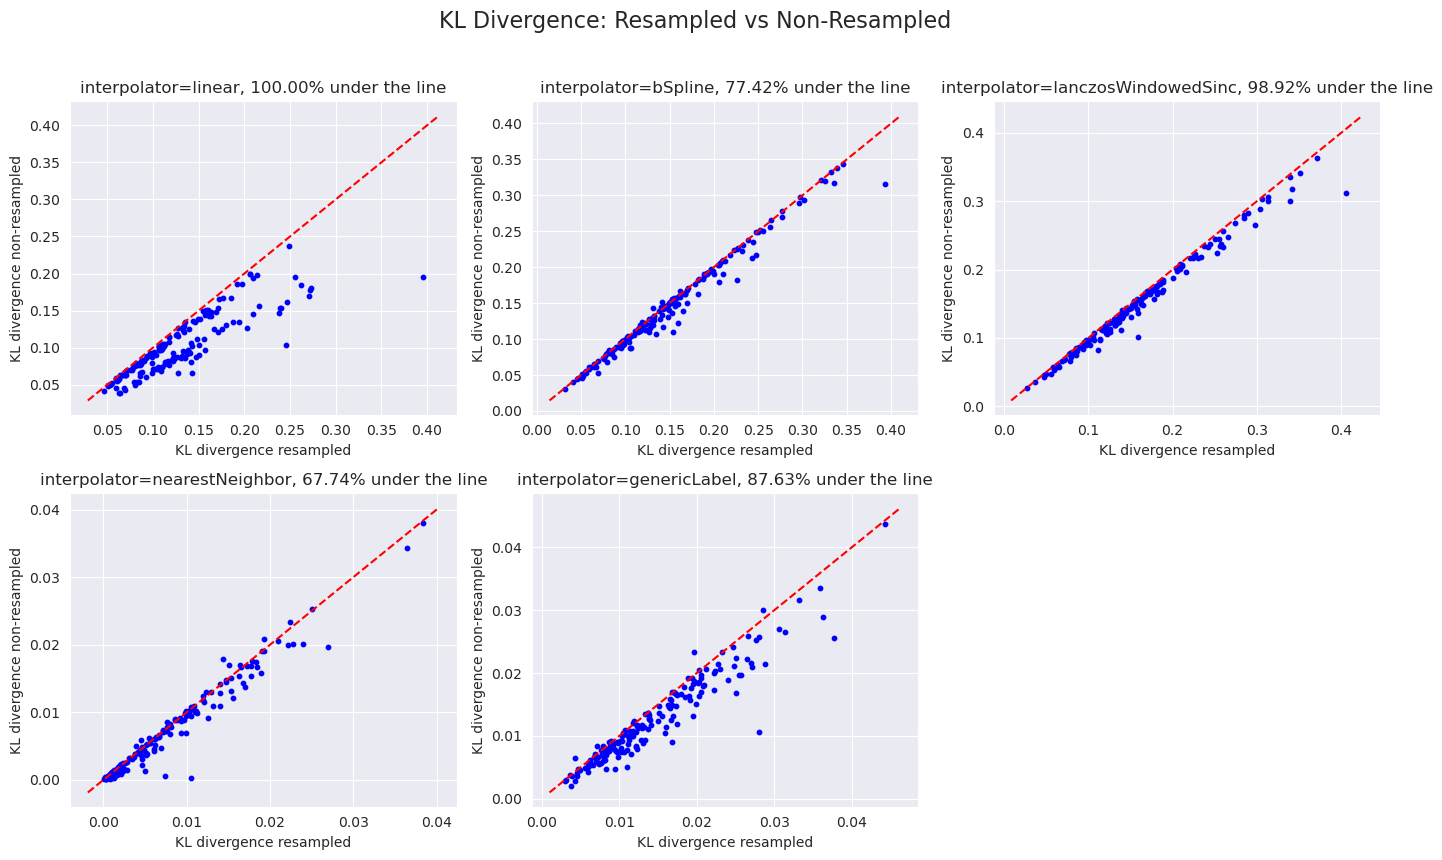

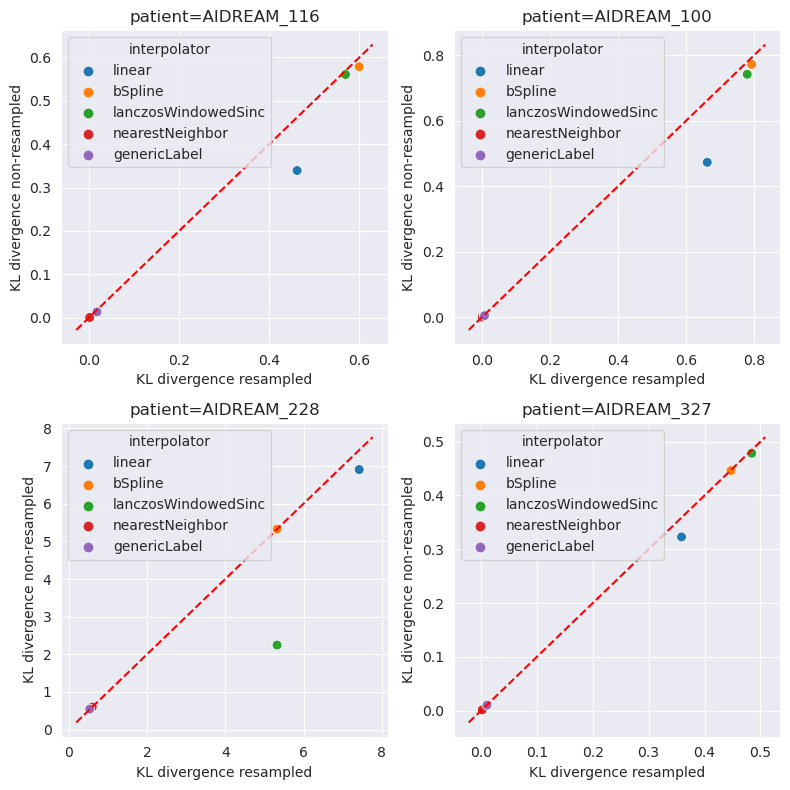

In [41]:
# Scatter the patients per interpolator, based on KL divergence resampled and KL divergence non-resampled (CTH):

# Create the figure
fig = plt.figure(figsize=(14, 9))
fig.suptitle("KL Divergence: Resampled vs Non-Resampled", fontsize=16, y=0.95)

for idx, interpolator in enumerate(list_interpolators):

    df_interpolator = df_js_divergence.loc[df_js_divergence["interpolator"] == interpolator]
    df_no_outliers = df_interpolator.loc[~df_interpolator["patient"].isin(outliers)]

    ax = fig.add_subplot(2, 3, idx+1)
    ax.scatter(df_no_outliers["KL divergence resampled"], df_no_outliers["KL divergence non-resampled"], s=10, c="blue")
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], "--", c="red")

    under_line = df_interpolator.loc[df_interpolator["KL divergence resampled"] > df_interpolator["KL divergence non-resampled"]]
    pct_under_line = 100 * len(under_line) / len(df_interpolator)

    ax.set_xlabel("KL divergence resampled")
    ax.set_ylabel("KL divergence non-resampled")
    ax.set_title(f"interpolator={interpolator}, {pct_under_line:.2f}% under the line")

# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Plot the outliers :
n_rows = int(np.ceil(np.sqrt(len(outliers))))
fig = plt.figure(figsize=(4 * n_rows, 4 * n_rows))

# Initialize a list to collect legend handles and labels
handles, labels = [], []

for i, patient in enumerate(outliers):

    ax = fig.add_subplot(n_rows, n_rows, i+1)
    _df = df_js_divergence.loc[df_js_divergence["patient"] == patient]

    scatter = sns.scatterplot(data=_df, x="KL divergence resampled", y="KL divergence non-resampled", ax=ax,
                              s=50, hue="interpolator", palette="tab10")

    ax.set_title(f"patient={patient}")
    ax.plot(ax.get_xlim(), ax.get_xlim(), "--", c="red")

plt.tight_layout()  # Adjust layout to make space for the legend
plt.show()


In [57]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='red', marker=None,
            linestyle='--', linewidth=1.0)

In [58]:
cols = ["patient", "interpolator", "KL divergence non-resampled"]
df_no_outliers_non_resampled = df_js_divergence[cols].loc[~df_js_divergence["patient"].isin(outliers)].copy()
df_no_outliers_non_resampled.groupby("interpolator").describe()


KL divergence non-resampled                                \
                                          count      mean       std       min   
interpolator                                                                    
bSpline                                   182.0  0.145991  0.067526  0.031137   
genericLabel                              182.0  0.012524  0.006877  0.002090   
lanczosWindowedSinc                       182.0  0.150693  0.067899  0.026769   
linear                                    182.0  0.100738  0.039684  0.038660   
nearestNeighbor                           182.0  0.006717  0.006825  0.000066   

                                                             
                          25%       50%       75%       max  
interpolator                                                 
bSpline              0.099713  0.135235  0.183780  0.343284  
genericLabel         0.007452  0.010805  0.016857  0.043716  
lanczosWindowedSinc  0.101878  0.142272  0.181803  0.363621  
linear               0.070771  0.091878  0.125419  0.237366  
nearestNeighbor      0.001210  0.004543  0.010188  0.038064

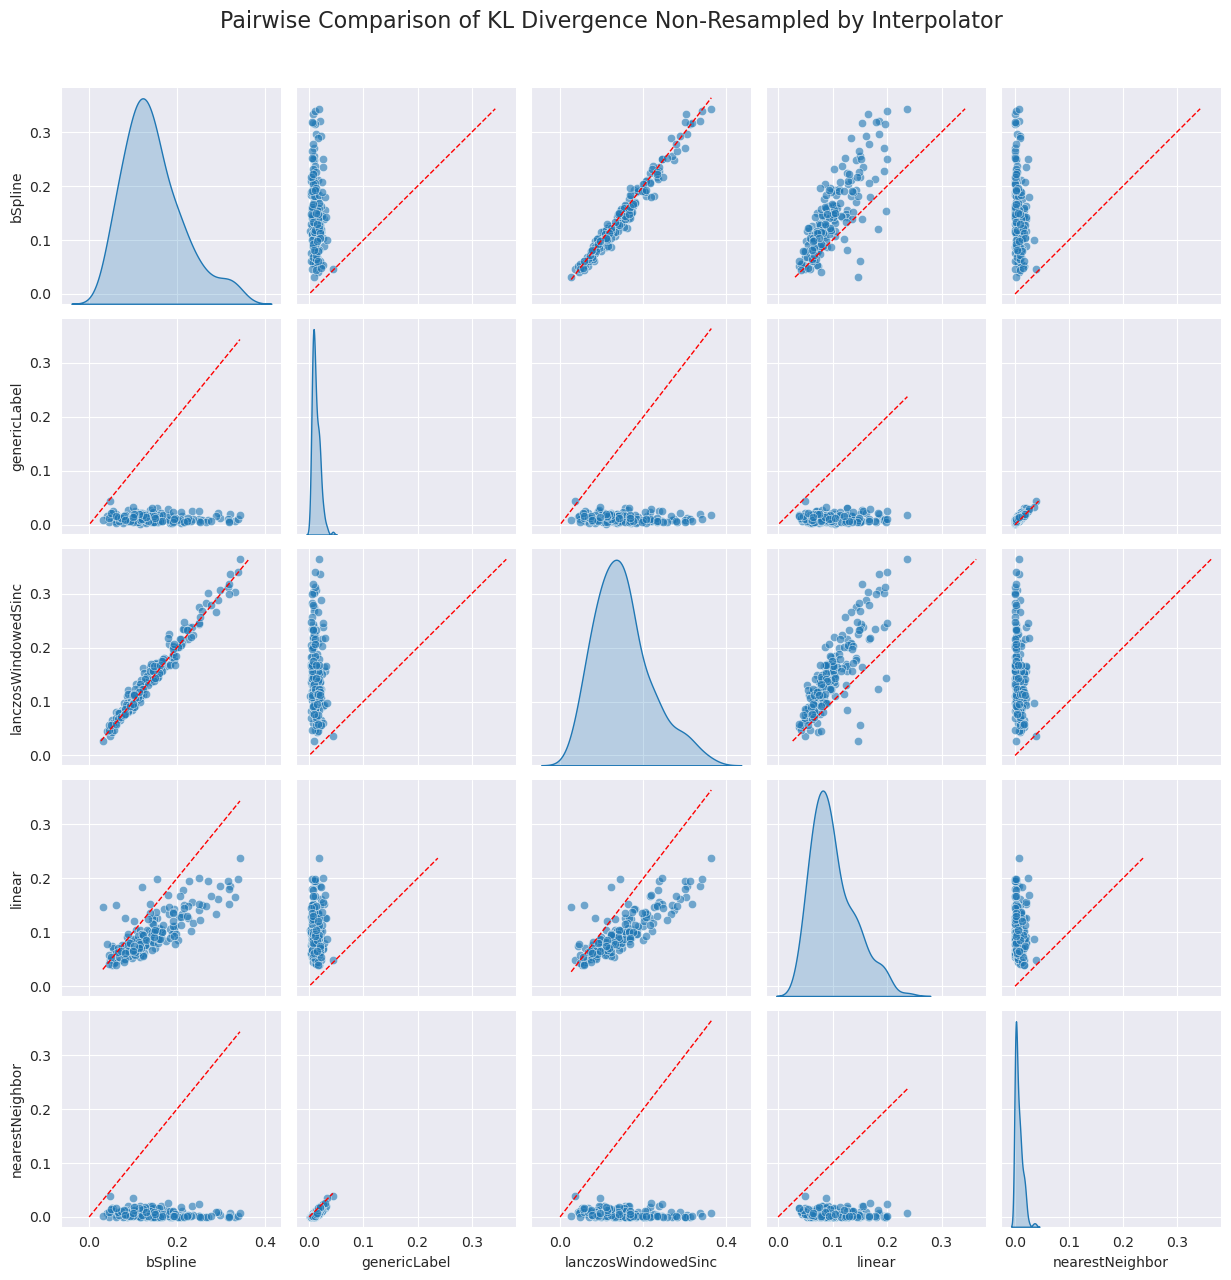

In [59]:
# Prepare the data for pairwise comparisons
df_pairwise = df_no_outliers_non_resampled.pivot(
    index="patient", columns="interpolator", values="KL divergence non-resampled"
).reset_index()

# Plot the pairplot with KDE on the diagonal
pairplot = sns.pairplot(
    df_pairwise,
    diag_kind="kde",  # Kernel density plot on the diagonal
    kind="scatter",   # Scatter plot for pairwise relationships
    plot_kws={"alpha": 0.6},  # Transparency for scatter points
    diag_kws={"fill": True}  # Fill the diagonal density plots
)

pairplot.map_offdiag(plot_unity)

# Add a title to the entire plot
plt.suptitle("Pairwise Comparison of KL Divergence Non-Resampled by Interpolator", y=1.02, fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
# register brainmask for all patients, genericLabel interpolator :
for i, patient in enumerate(list_patients):

    print(fr"Processing patient {i+1}/{len(list_patients)} : {patient}")
    padder = ImprovedPadding(patient)

    for resample in [True, False]:

        print(fr"Registering brainmask for patient={patient}, resample={resample}, interpolator=genericLabel")

        padder.register("brainmask", resample=resample, interpolator="genericLabel")


Processing patient 1/3 : AIDREAM_1
Registering brainmask for patient=AIDREAM_1, resample=True, interpolator=genericLabel
Registering brainmask for patient=AIDREAM_1, resample=False, interpolator=genericLabel
Processing patient 2/3 : AIDREAM_2
Registering brainmask for patient=AIDREAM_2, resample=True, interpolator=genericLabel
Registering brainmask for patient=AIDREAM_2, resample=False, interpolator=genericLabel
Processing patient 3/3 : AIDREAM_3
Registering brainmask for patient=AIDREAM_3, resample=True, interpolator=genericLabel
Registering brainmask for patient=AIDREAM_3, resample=False, interpolator=genericLabel
